In [3]:
from helpers import *

In [14]:
s3 = s3_connection()
df = s3.get_tables_from_s3("aayrapetyan/diffusion/final_table.parquet")
df.sample(3)

connection successful


,total_voyageurs_2022,nom_gare,uic,codeinsee,lon_gare,lat_gare,codecommune,nomcommune,pop2022,revmoy2022,...,psup2022,pagri2022,pindp2022,pcadr2022,ppint2022,pempl2022,pouvr2022,pchom2022,dist_closest_station_km,regions
1779,61949,Briare,87696088,45053,2.733715,47.646431,45053,BRIARE,5072.0,17182.740,...,0.250325,0.000000,0.119228,0.079765,0.240974,0.390428,0.169605,0.046180,9.358870,Centre-Val de Loire
2278,158901,Beynes,87393363,78062,1.875570,48.859360,78062,BEYNES,7338.0,25354.850,...,0.465820,0.002460,0.118491,0.223452,0.382944,0.200492,0.072161,0.059861,3.827763,Île-de-France
1540,1809687,Perpignan,87784009,66136,2.879779,42.696292,66136,PERPIGNAN,126187.0,13298.188,...,0.302855,0.002242,0.078550,0.117573,0.256014,0.325314,0.220307,0.149523,7.349559,Occitanie


In [15]:
def calculate(df: pd.DataFrame, group, fields_stats_names) -> pd.DataFrame:

    table = None

    # calculer pour chaque couple des variables et statistiques
    # une des limites: ne pas utiliser les mêmes variables dans groupe et field
    for field_stat_name in fields_stats_names:
        field, stat = field_stat_name[0], field_stat_name[1]
        try:
            name = field_stat_name[2]
        except:
            name = f"{field}_{stat}"

        v = (
            df.groupby(group)[field]
            .agg(stat)
            .reset_index()
            .rename(columns={field: name})
        )

        if table is None:
            table = v
        else:
            table = table.merge(v, on=group, how="left")

    return table

In [16]:
df.columns

Index(['total_voyageurs_2022', 'nom_gare', 'uic', 'codeinsee', 'lon_gare',
       'lat_gare', 'codecommune', 'nomcommune', 'pop2022', 'revmoy2022',
       'pbac2022', 'psup2022', 'pagri2022', 'pindp2022', 'pcadr2022',
       'ppint2022', 'pempl2022', 'pouvr2022', 'pchom2022',
       'dist_closest_station_km', 'regions'],
      dtype='object')

In [17]:
aggregated_stats = calculate(
    df,
    group=["regions"],
    fields_stats_names=[
        ["total_voyageurs_2022", "sum"],
        ["pop2022", "sum"],
        ["revmoy2022", "mean"],
        ["pbac2022", "mean"],
        ["pagri2022", "mean"],
        ["pindp2022", "mean"],
        ["pcadr2022", "mean"],
        ["pempl2022", "mean"],
        ["pouvr2022", "mean"],
        ["pchom2022", "mean"],
        
    ],
)
df = df.merge(aggregated_stats, on="regions", how="inner")

In [18]:
df.sample(1)

,total_voyageurs_2022,nom_gare,uic,codeinsee,lon_gare,lat_gare,codecommune,nomcommune,pop2022,revmoy2022,...,total_voyageurs_2022_sum,pop2022_sum,revmoy2022_mean,pbac2022_mean,pagri2022_mean,pindp2022_mean,pcadr2022_mean,pempl2022_mean,pouvr2022_mean,pchom2022_mean
2722,38867,Saint-Sulpice-Laurière,87592345,87181,1.476222,46.046918,87181,ST-SULPICE-LAURIERE,795.0,15785.905,...,67335302,3090545.0,16809.41033,0.430025,0.022356,0.085035,0.108294,0.307585,0.238222,0.07651


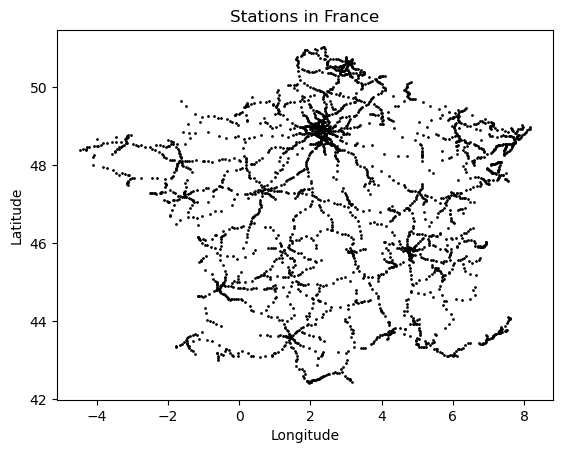

In [19]:
simple_plot_map(lat=df["lat_gare"], lon=df["lon_gare"])

nb removed observations :  18


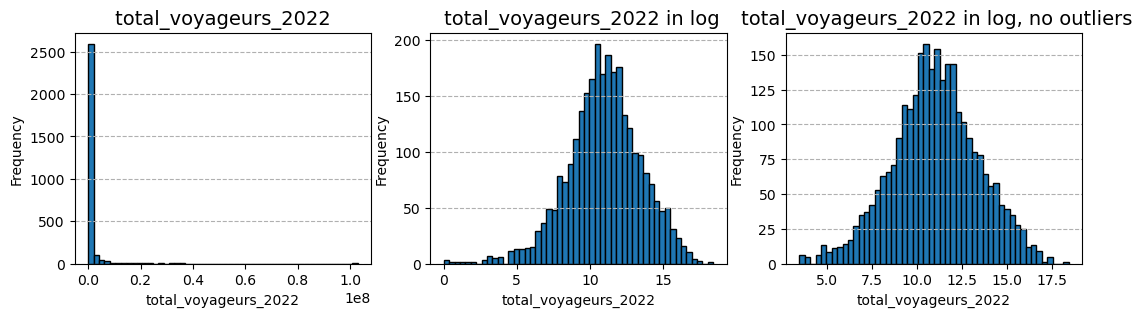

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(13, 3))  # 3 rows, 1 column of plots
no_outliers_table = delete_outliers_z_score(df, np.log(df["total_voyageurs_2022"]))
plot_hist(axs[0], df["total_voyageurs_2022"], title_suffix="")
plot_hist(axs[1], np.log(df["total_voyageurs_2022"]), title_suffix="in log")
plot_hist(
    axs[2],
    np.log(no_outliers_table["total_voyageurs_2022"]),
    title_suffix="in log, no outliers",
)

In [46]:
def plot_square_map(lat,lon,fields_names, nb_axis=3, figsize=(28, 28)):
    fig, axs = plt.subplots(nb_axis, nb_axis, figsize=figsize) 
    axs = axs.flatten()  # Flatten for easier iteration
    for idx, el in enumerate(fields_names):
        field = el[0]
        name = el[1]
        ax = axs[idx]  # Select the correct subplot
        #use another function
        plot_map_with_legend(
            ax,
            lon,
            lat,
            field,
            suffix_description=name,
        )
    
    #delete duplicated legends
    for ax in axs[len(fields_names):]:
        ax.axis("off") 

  
    plt.show()


In [ ]:
no_outliers_table["lon_gare"],
            no_outliers_table["lat_gare"],

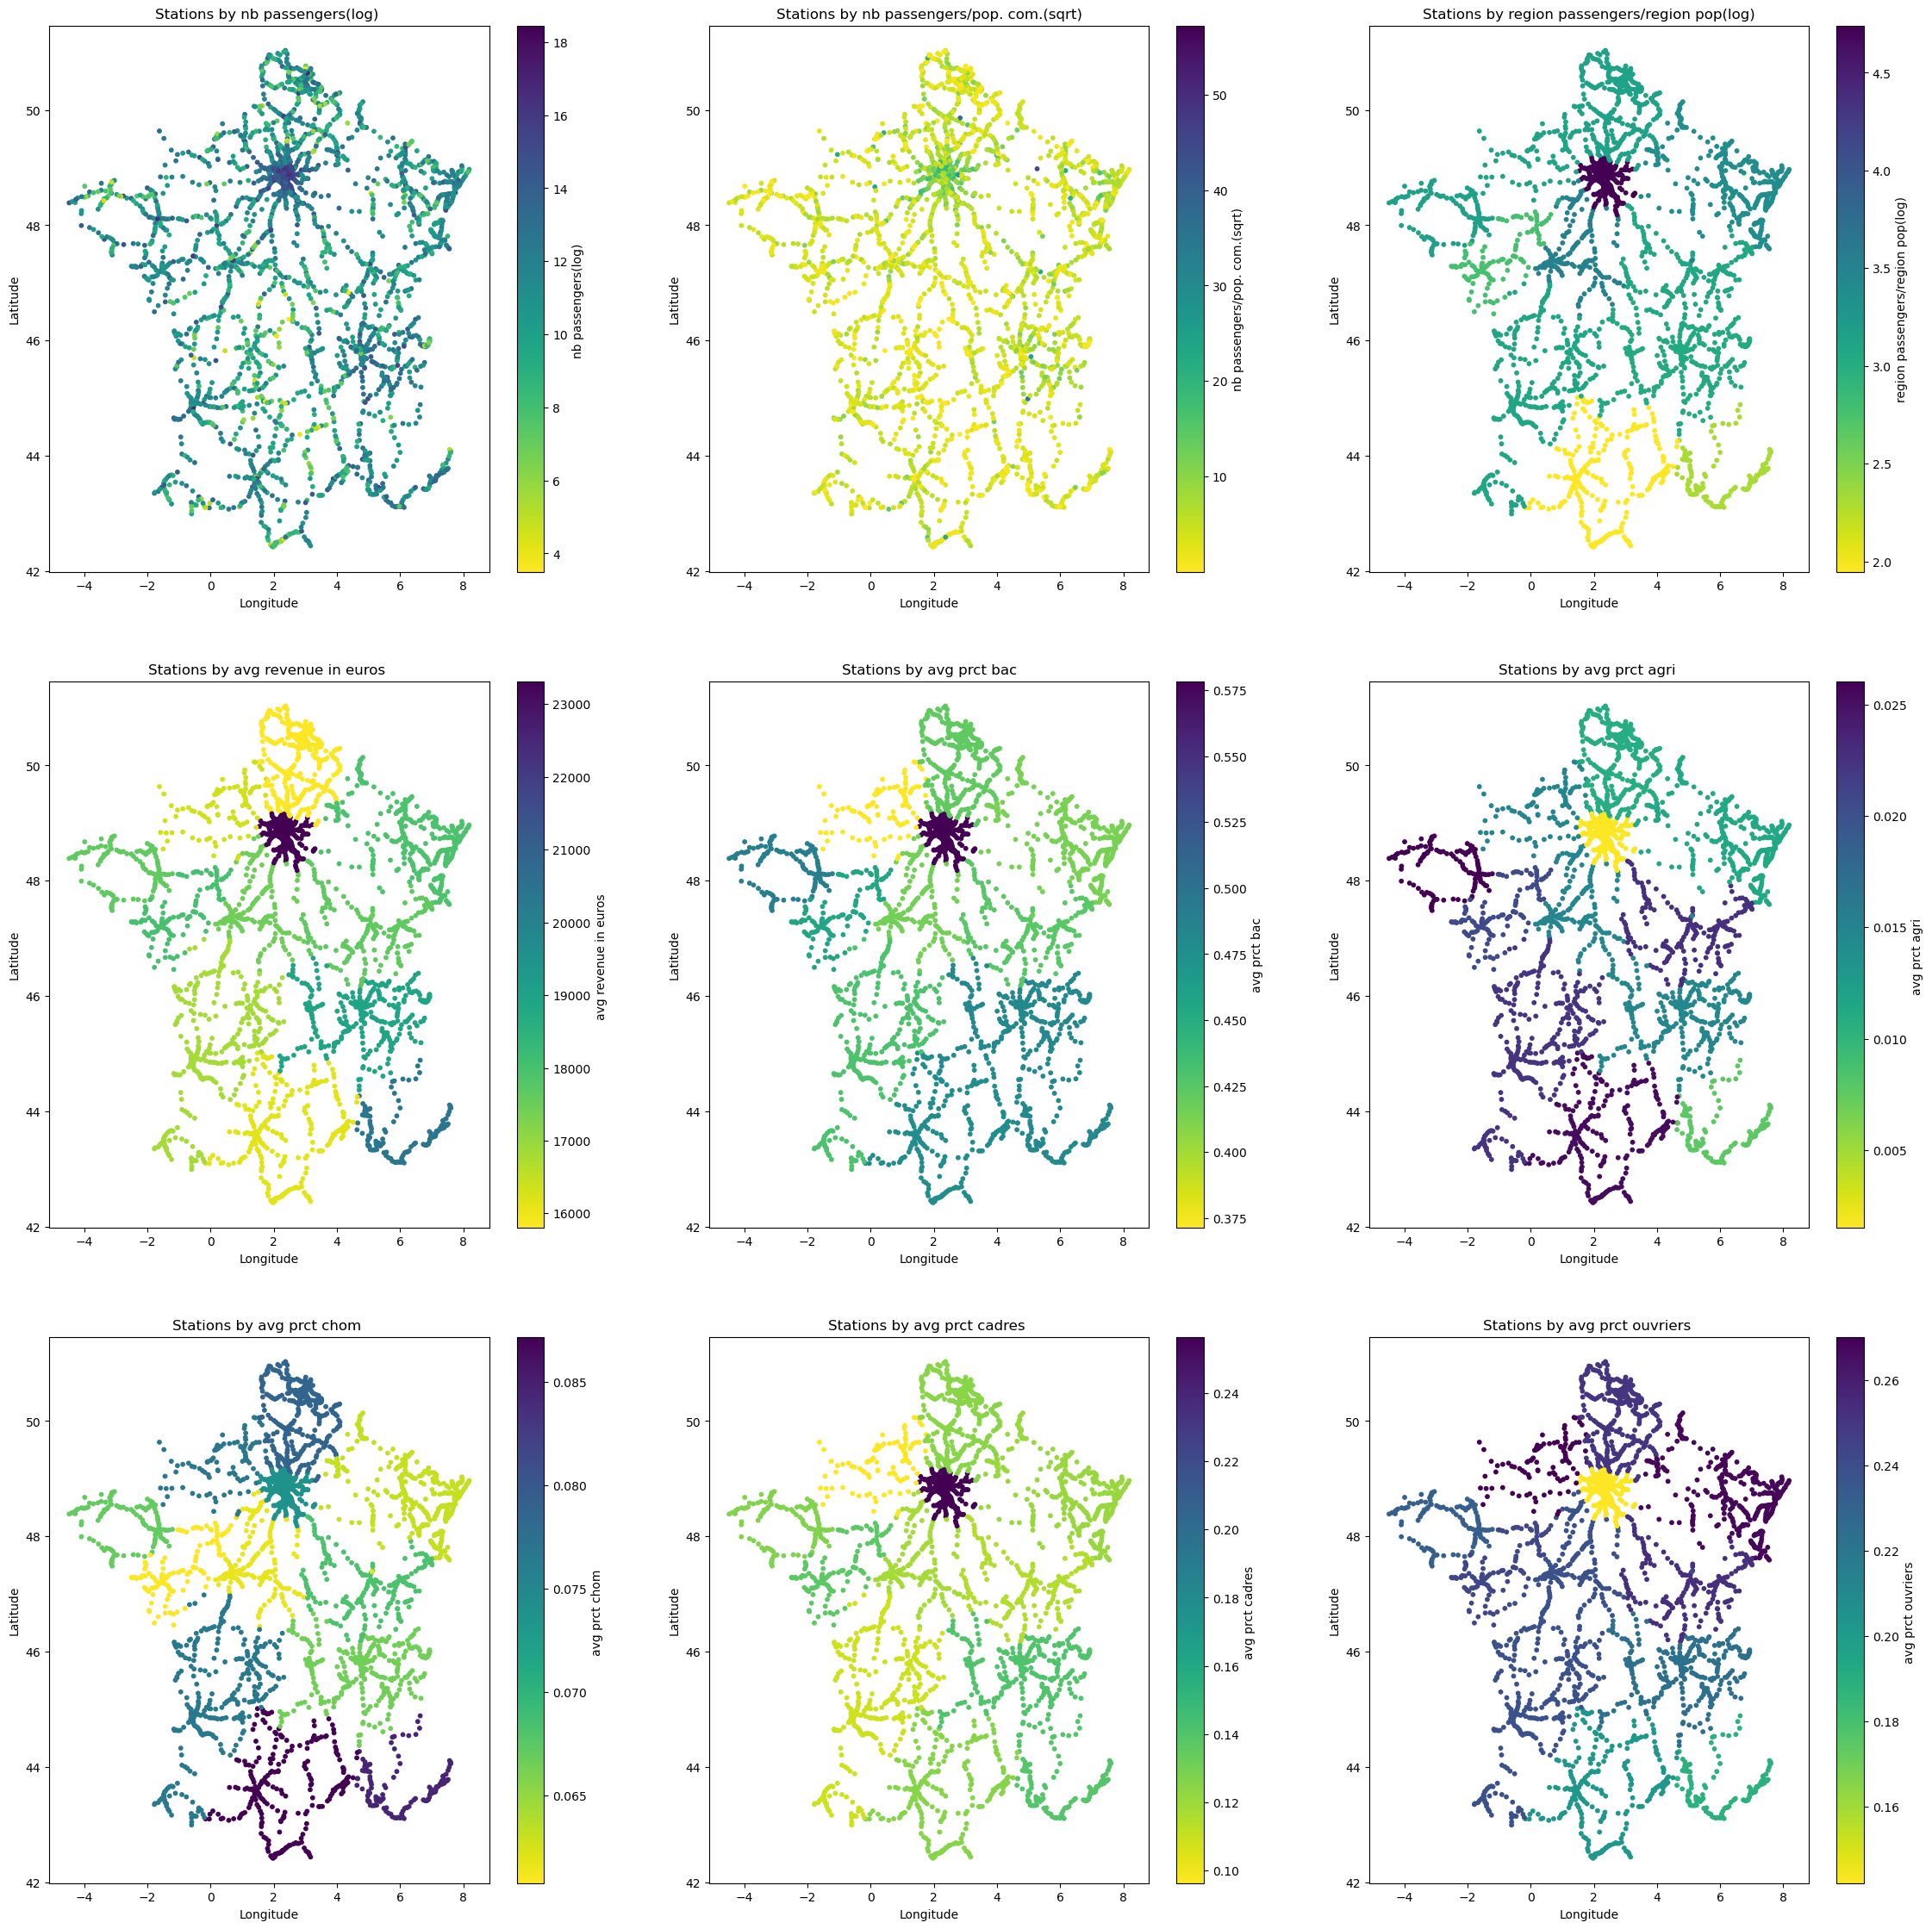

In [47]:
plot_square_map(lon=no_outliers_table["lon_gare"],lat=no_outliers_table["lat_gare"],
    fields_names=[
        [np.log(no_outliers_table["total_voyageurs_2022"]), "nb passengers(log) "],
        [
            np.sqrt(
                no_outliers_table["total_voyageurs_2022"] / no_outliers_table["pop2022"]
            ),
            "nb passengers/pop. com.(sqrt)",
        ],
        [
            np.log(
                no_outliers_table["total_voyageurs_2022_sum"]
                / no_outliers_table["pop2022_sum"]
            ),
            "region passengers/region pop(log)",
        ],
        [
            (no_outliers_table["revmoy2022_mean"]),
            "avg revenue in euros ",
        ],
        [
            no_outliers_table["pbac2022_mean"],
            "avg prct bac",
        ],
        [
            no_outliers_table["pagri2022_mean"],
            "avg prct agri ",
        ],
        [
            (no_outliers_table["pchom2022_mean"]),
            "avg prct chom ",
        ],
        [
            no_outliers_table["pcadr2022_mean"],
            "avg prct cadres ",
        ],
        [
            no_outliers_table["pouvr2022_mean"],
            "avg prct ouvriers ",
        ],
    ]
)

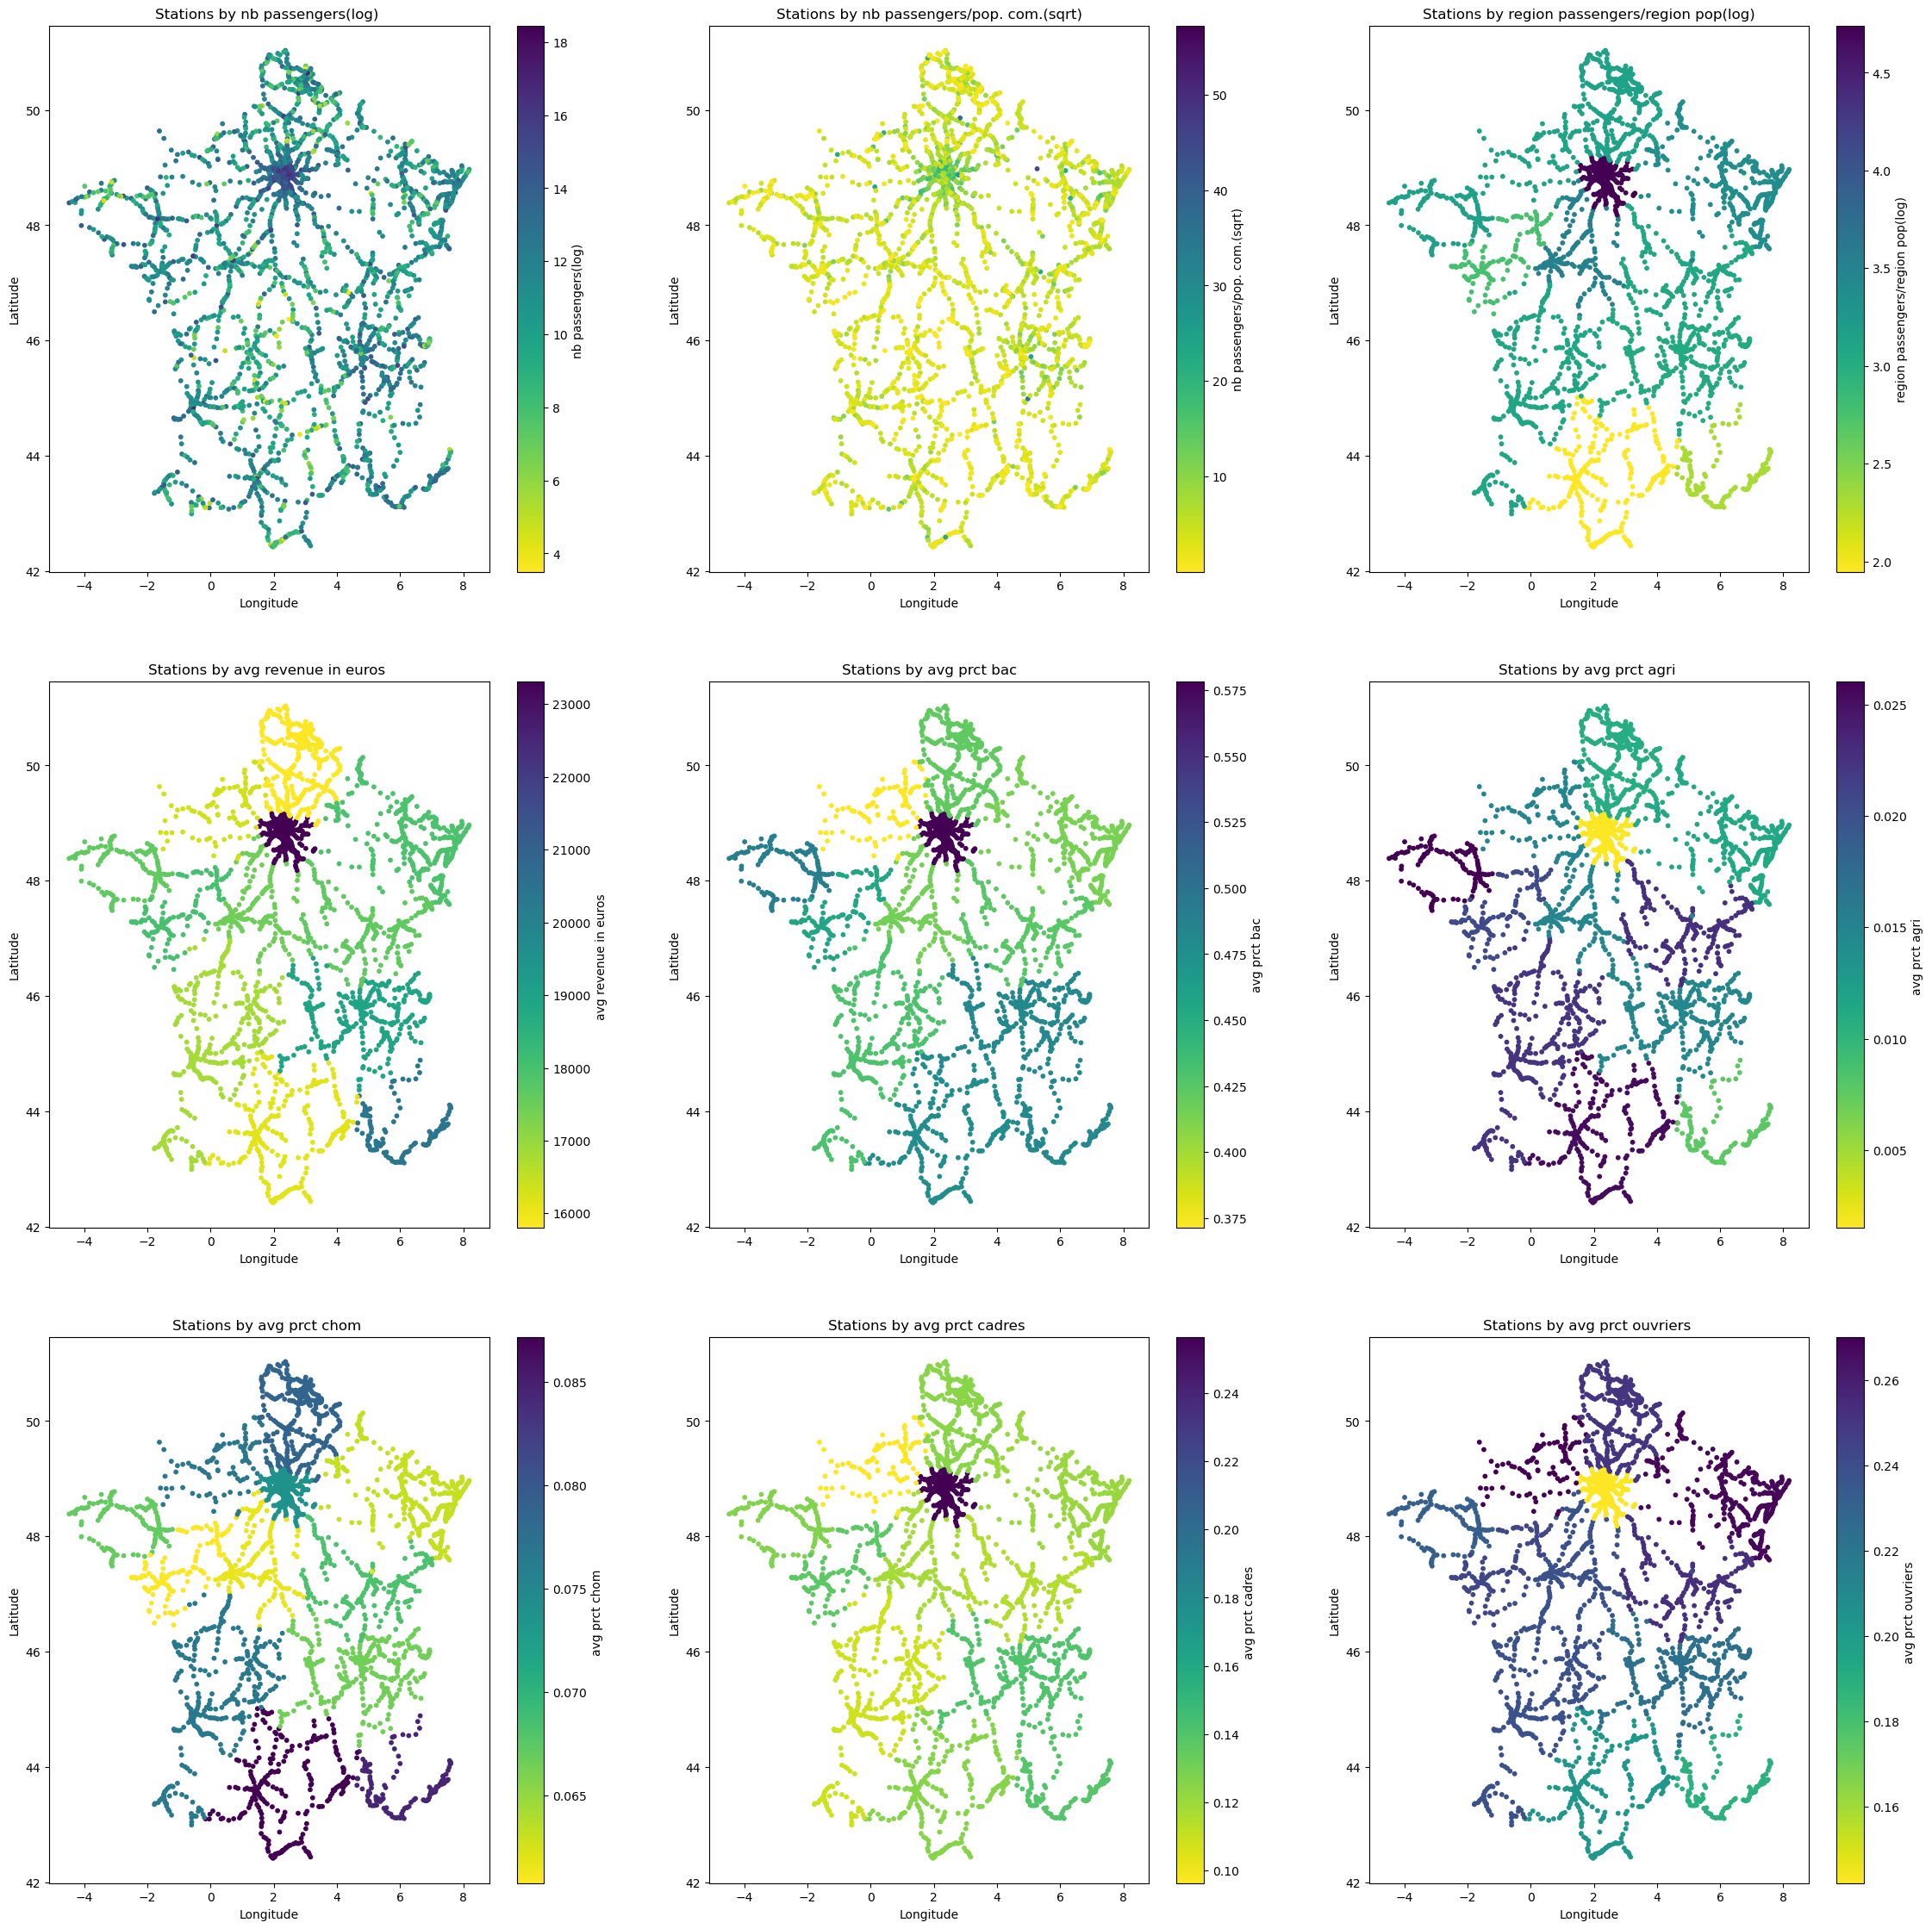

In [23]:
fig, axs = plt.subplots(3, 3, figsize=(28, 28))  # 2 rows, 1 column of plots


plot_map_with_legend(
    axs[0, 0],
    no_outliers_table["lon_gare"],
    no_outliers_table["lat_gare"],
    np.log(no_outliers_table["total_voyageurs_2022"]),
    suffix_description="nb passengers(log) ",
)
plot_map_with_legend(
    axs[0, 1],
    no_outliers_table["lon_gare"],
    no_outliers_table["lat_gare"],
    np.sqrt(no_outliers_table["total_voyageurs_2022"] / no_outliers_table["pop2022"]),
    suffix_description="nb passengers/pop. com.(sqrt)",
)
plot_map_with_legend(
    axs[0, 2],
    no_outliers_table["lon_gare"],
    no_outliers_table["lat_gare"],
    np.log(no_outliers_table["total_voyageurs_2022_sum"] / no_outliers_table["pop2022_sum"]),
    suffix_description="region passengers/region pop(log)",
)

plot_map_with_legend(
    axs[1, 0],
    no_outliers_table["lon_gare"],
    no_outliers_table["lat_gare"],
    (no_outliers_table["revmoy2022_mean"]),
    suffix_description="avg revenue in euros ",
)
plot_map_with_legend(
    axs[1, 1],
    no_outliers_table["lon_gare"],
    no_outliers_table["lat_gare"],
    no_outliers_table["pbac2022_mean"],
    suffix_description="avg prct bac",
)
plot_map_with_legend(
    axs[1, 2],
    no_outliers_table["lon_gare"],
    no_outliers_table["lat_gare"],
    no_outliers_table["pagri2022_mean"],
    suffix_description="avg prct agri ",
)
plot_map_with_legend(
    axs[2, 0],
    no_outliers_table["lon_gare"],
    no_outliers_table["lat_gare"],
    (no_outliers_table["pchom2022_mean"]),
    suffix_description="avg prct chom ",
)
plot_map_with_legend(
    axs[2, 1],
    no_outliers_table["lon_gare"],
    no_outliers_table["lat_gare"],
    no_outliers_table["pcadr2022_mean"],
    suffix_description="avg prct cadres ",
)
plot_map_with_legend(
    axs[2, 2],
    no_outliers_table["lon_gare"],
    no_outliers_table["lat_gare"],
    no_outliers_table["pouvr2022_mean"],
    suffix_description="avg prct ouvriers ",
)